# ***Benchmark RFFGM vs GPGM on noisy predator–prey time–series***
---

In [ ]:
using Random, LinearAlgebra, Statistics, Dates, Printf
using DifferentialEquations
using KernelFunctions
using Distributions
using RFFGradientMatching
using AbstractMCMC, MCMCChains, MCMCDiagnosticTools
using JLD2, CSV, DataFrames, Plots
using ProgressMeter

default(size=(800,400))

0.  GLOBAL SETTINGS

In [2]:
const N_REP       = 1                 # replicates / cell
const OBS_NOISE   = 0.10
const TSPAN       = (0.0, 2.0)
const MCMC_ITERS  = 10_000
const BURN_IN     = 5_000
const RESULTS_DIR = joinpath(@__DIR__, "results")
mkpath(RESULTS_DIR)
PLOT_DIR    = joinpath(RESULTS_DIR, "plots")
mkpath(PLOT_DIR)

const N_GRID = [10, 25, 40]   # data length
const L_GRID = [50, 100, 200]       # RFF dimension
linestyles = Dict(10=>:solid, 25=>:dash, 40=>:dot)

Dict{Int64, Symbol} with 3 entries:
  25 => :dash
  10 => :solid
  40 => :dot

1. TRUE MODEL (constant across cells)

In [ ]:
true_params = [2.0, 1.0, 4.0, 1.0]          # α,β,δ,γ
u0          = [5.0, 3.0]
pp!         = RFFGradientMatching.lotkavolterrapredatorprey!

α², ℓ = 1.0, 1.0
kernel = α² * with_lengthscale(RBFKernel(), ℓ)

Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- Scale Transform (s = 1.0)
	- σ² = 1.0

2. HELPERS

In [4]:
function ess_per_sec(chain::Chains)
    ess = MCMCDiagnosticTools.ess(chain).nt.ess
    return mean(ess) / (MCMC_ITERS - BURN_IN)
end

rmse(θ̄) = sqrt(mean((θ̄ .- true_params).^2))

rmse (generic function with 1 method)

3. SINGLE‑RUN WORKER  (no inducing points)

function run_cell(N::Int, L::Int, rep::Int)
    rng = MersenneTwister(10_000*N + 100*L + rep)

    obs_times = range(TSPAN[1], TSPAN[2], length=N) |> collect
    prob_true = ODEProblem(pp!, u0, TSPAN, true_params)
    sol_true  = solve(prob_true, Tsit5(), saveat=obs_times)
    y_true    = Array(sol_true)
    y_obs     = y_true .+ OBS_NOISE * randn(rng, size(y_true))

    ## --- GPGM --------------------------------------------------
    gm_gp = GPGM(obs_times, y_obs, prob_true, "PredatorPrey";
                 k=kernel,                     # FULL GP
                 state_noise_std=1e-4, obs_noise_std=OBS_NOISE)
    optimize_ϕ_and_σ!(gm_gp)
    bs_gp = BlockedSampler([[HMCBlock(gm_gp, [:X,:θ], n_leapfrog=10, step_size=0.05, metric=:diag)]], [1.0])

    init_gm_gp = pack_param_dict(gm_gp)
    t_gp = @elapsed chain_gp = sample(rng, gm_gp, bs_gp, MCMC_ITERS; init_params=init_gm_gp, num_burnin=BURN_IN)
    ess_gp  = ess_per_sec(Chains(get_θ(gm_gp, chain_gp)))
    θ̄_gp   = mean(get_θ(gm_gp, chain_gp), dims=1)[:]
    rmse_gp = rmse(θ̄_gp)

    ## --- RFFGM -------------------------------------------------
    gm_rf = RFGM(obs_times, y_obs, prob_true, "PredatorPrey";
                 k=kernel, n_rff=L,
                 state_noise_std=1e-4, obs_noise_std=OBS_NOISE)
    optimize_ϕ_and_σ!(gm_rf)
    bs_rf = BlockedSampler([[HMCBlock(gm_rf, [:W,:θ], n_leapfrog=10, step_size=0.05, metric=:diag)]], [1.0])

    init_gm_rf = pack_param_dict(gm_rf)
    t_rf = @elapsed chain_rf = sample(rng, gm_rf, bs_rf, MCMC_ITERS; init_params=init_gm_rf, num_burnin=BURN_IN)
    ess_rf  = ess_per_sec(Chains(get_θ(gm_rf, chain_rf)))
    θ̄_rf   = mean(get_θ(gm_rf, chain_rf), dims=1)[:]
    rmse_rf = rmse(θ̄_rf)

    return (; N, L, rep,
            runtime_gp=t_gp, runtime_rf=t_rf,
            ess_gp, ess_rf, rmse_gp, rmse_rf,
            chain_gp, chain_rf, gm_gp, gm_rf)
end

In [ ]:
function run_gpgm(N::Int, rep::Int)
    rng        = MersenneTwister(10_000*N + rep)
    t_obs      = collect(range(TSPAN[1], TSPAN[2], length=N))
    prob_true  = ODEProblem(pp!, u0, TSPAN, true_params)
    y_true     = Array(solve(prob_true, Tsit5(), saveat=t_obs))
    y_obs      = y_true .+ OBS_NOISE * randn(rng, size(y_true))

    gm_gp = GPGM(t_obs, y_obs, prob_true, "PredatorPrey";
                 k=kernel, state_noise_std=1e-3, obs_noise_std=OBS_NOISE)
    optimize_ϕ_and_σ!(gm_gp)
    bs = BlockedSampler([[HMCBlock(gm_gp, [:X,:θ], n_leapfrog=10, step_size=0.05, metric=:diag)]],[1.0])
    init_gm_gp = pack_param_dict(gm_gp)
    chain_gp, logdens_gp = sample(rng, gm_gp, bs, MCMC_ITERS; init_params=init_gm_gp, num_burnin=BURN_IN)

    θ_samples = get_θ(gm_gp, chain_gp[BURN_IN+1:end])
    ess_gp  = ess_per_sec(Chains(θ_samples))
    sqdiff_θ_samples = [(s .- true_params).^2 |>sum for s in θ_samples]
    mean_θ = mean(θ_samples, dims=1)[:]
    std_θ = std(θ_samples, dims=1)[:]
    rmsd_gp = sqrt(mean(sqdiff_θ_samples))

    return t_obs, y_obs, prob_true,
        (N=N, rep=rep, logdens=logdens_gp, ess=ess_gp, rmsd=rmsd_gp,
        mean_θ=mean_θ, std_θ=std_θ, chain=chain_gp, gm=gm_gp)
end

function run_rffgm(t_obs, y_obs, prob, N::Int, L::Int, rep::Int, seed::Int)
    rng = MersenneTwister(seed)
    gm_rf = RFFGM(t_obs, y_obs, prob, "PredatorPrey";
                 k=kernel, n_rff=L, state_noise_std=1e-3, obs_noise_std=OBS_NOISE)
    optimize_ϕ_and_σ!(gm_rf)
    bs = BlockedSampler([[HMCBlock(gm_rf, [:W,:θ], n_leapfrog=10, step_size=0.05, metric=:diag)]], [1.0])
    init_gm_rf = pack_param_dict(gm_rf)
    chain_rf, logdens_rf = sample(rng, gm_rf, bs, MCMC_ITERS; init_params=init_gm_rf, num_burnin=BURN_IN)

    θ_samples = get_θ(gm_rf, chain_rf[BURN_IN+1:end])
    ess_rf  = ess_per_sec(Chains(θ_samples))
    sqdiff_θ_samples = [(s .- true_params).^2 |>sum for s in θ_samples]
    mean_θ = mean(θ_samples, dims=1)[:]
    std_θ = std(θ_samples, dims=1)[:]
    rmsd_rf = sqrt(mean(sqdiff_θ_samples))

    return (N=N, L=L, rep=rep,
            logdens=logdens_rf, ess=ess_rf, rmsd=rmsd_rf,
            mean_θ=mean_θ, std_θ=std_θ,
            chain=chain_rf, gm=gm_rf)
end

run_rffgm (generic function with 1 method)

4. FACTORIAL EXECUTION

@showprogress "Running grid…" for N in N_GRID, L in L_GRID, rep in 1:N_REP
    out = run_cell(N, L, rep)

    cell_dir = joinpath(RESULTS_DIR, @sprintf("NL=%d-%d", N, L))
    mkpath(cell_dir)
    @save joinpath(cell_dir, "rep$(rep).jld2") out
end

In [7]:
gpgm_df  = DataFrame();  rffgm_df = DataFrame()

@showprogress "Running experiments…" for N in N_GRID, rep in 1:N_REP
    # -- GPGM once per (N,rep)
    t_obs, y_obs, prob, res_gp = run_gpgm(N, rep)

    # save GPGM artefacts
    gdir = joinpath(RESULTS_DIR, "GPGM", @sprintf("N=%03d", N))
    mkpath(gdir)
    @save joinpath(gdir, "rep$(rep).jld2") res_gp
    push!(gpgm_df, (
        N=N, rep=rep, ess=res_gp.ess, rmsd=res_gp.rmsd))

    # -- RFFGM for every L on the SAME data
    for L in L_GRID
        seed = 1_000_000*N + 1_000*L + rep
        res_rf = run_rffgm(t_obs, y_obs, prob, N, L, rep, seed)

        rdir = joinpath(RESULTS_DIR, "RFFGM", @sprintf("N=%03d-L=%03d",N,L))
        mkpath(rdir)
        @save joinpath(rdir, "rep$(rep).jld2") res_rf

        push!(rffgm_df, (
            N=N, L=L, rep=rep, ess=res_rf.ess, rmsd=res_rf.rmsd))
    end
end

Progress: 10000 / 10000 [████████████████████] 100.0%
Latest logdensity: 399.384

 ┌────────────────────────────────────────────────────────────┐ 
 1 000 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
 │⠀⠀⠀⢀⣠⡤⠤⠤⠤⠤⠶⠶⠶⠶⠶⠶⠶⠶⠶⠶⠖⠒⠖⠲⠒⠒⠒⠒⠲⠶⠲⠒⠖⠒⠲⠲⠲⠲⠶⠶⠶⠖⠲⠶⠖⠶⠶⠶⠶⠶⠶⠶⠶⠶⠶⠶⠶⠶⠶⠶│ 
 │⠤⢤⡾⠭⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤│ 
 │⠀⡏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
 │⢸⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
 │⡞⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
 │⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
 -3 000 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
 └────────────────────────────────────────────────────────────┘ 
 ⠀0⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀10 000⠀

Running experiments… 100%|███████████████████████████████| Time: 6:42:26


In [17]:
CSV.write(joinpath(RESULTS_DIR, "GPGM", "gpgm_df.csv"), gpgm_df)
CSV.write(joinpath(RESULTS_DIR, "RFFGM", "rffgm_df.csv"), rffgm_df)

"/Users/shuichimiyazawa/github_local/package_development/EventODEModeling/experiments/comparison/results/RFFGM/rffgm_df.csv"

In [27]:
gpgm_df

Row,N,rep,ess,rmsd
,Int64,Int64,Float64,Float64
1,10,1,0.00318772,0.761899
2,25,1,0.046849,0.841198
3,40,1,0.0379253,0.824859


In [16]:
rffgm_df

Row,N,L,rep,ess,rmsd
,Int64,Int64,Int64,Float64,Float64
1,10,50,1,0.00501162,0.755474
2,10,100,1,0.00316526,0.758153
3,10,200,1,0.00503978,0.755535
4,25,50,1,0.0532824,0.817686
5,25,100,1,0.0201845,0.850367
6,25,200,1,0.0347183,0.841568
7,40,50,1,0.050299,0.796564
8,40,100,1,0.0426516,0.814759
9,40,200,1,0.0182677,0.803516


5. WRITE CSVs

In [18]:
gpgm_df  = DataFrame();  rffgm_df = DataFrame()
for N in N_GRID, rep in 1:N_REP
    @load joinpath(RESULTS_DIR, "GPGM", @sprintf("N=%03d", N), "rep$(rep).jld2") res_gp
    push!(gpgm_df, (N=N, rep=rep, ess=res_gp.ess, rmsd=res_gp.rmsd))
end
for N in N_GRID, L in L_GRID, rep in 1:N_REP
    @load joinpath(RESULTS_DIR, "RFFGM", @sprintf("N=%03d-L=%03d", N, L), "rep$(rep).jld2") res_rf
    push!(rffgm_df, (N=N, L=L, rep=rep, ess=res_rf.ess, rmsd=res_rf.rmsd))
end

In [26]:

CSV.write(joinpath(RESULTS_DIR, "gpgm_summary.csv"), gpgm_df)
CSV.write(joinpath(RESULTS_DIR, "rffgm_summary.csv"), rffgm_df)

"/Users/shuichimiyazawa/github_local/package_development/EventODEModeling/experiments/comparison/results/rffgm_summary.csv"

6. PLOT LOGDENSITY TRACE

In [54]:
function load_gpgm_logdens()
    traces = Dict{Int,Vector{Float64}}()
    for N in N_GRID
        @load joinpath(RESULTS_DIR, "GPGM", @sprintf("N=%03d",N), "rep1.jld2") res_gp
        traces[N] = res_gp.logdens
    end
    return traces
end

function load_rffgm_logdens()
    traces = Dict{Int, Dict{Int,Vector{Float64}}}()
    for N in N_GRID
        traces[N] = Dict{Int,Vector{Float64}}()
        for L in L_GRID
            @load joinpath(RESULTS_DIR, "RFFGM", @sprintf("N=%03d-L=%03d",N,L), "rep1.jld2") res_rf
            traces[N][L] = res_rf.logdens
        end
    end
    return traces
end

load_rffgm_logdens (generic function with 2 methods)

In [55]:
gp_logdens_traces = load_gpgm_logdens()
rf_logdens_traces = load_rffgm_logdens()

Dict{Int64, Dict{Int64, Vector{Float64}}} with 3 entries:
  25 => Dict(50=>[-862.872, -886.968, -911.065, -935.161, -959.257, -983.353, -…
  10 => Dict(50=>[-213.561, -220.028, -226.495, -232.963, -239.43, -245.897, -2…
  40 => Dict(50=>[-1000.78, -1025.73, -1050.69, -1075.64, -1100.6, -1125.55, -1…

In [98]:
using Plots.PlotMeasures

In [140]:
pl = plot(gp_logdens_traces[10], c=:blue, lw=1.5, label="GPGM(N=10)")
plot!(gp_logdens_traces[25], c=:blue, ls=:dashdot, lw=1.5, label="GPGM(N=25)")
plot!(gp_logdens_traces[40], c=:blue, ls=:dash, lw=1.5, label="GPGM(N=40)")
plot!(rf_logdens_traces[10][100], c=:red, lw=1.5, label="RFFGM(N=10)")
plot!(rf_logdens_traces[25][100], c=:red, ls=:dashdot, lw=1.5, label="RFFGM(N=25)")
plot!(rf_logdens_traces[40][100], c=:red, ls=:dash, lw=1.5, label="RFFGM(N=40)")
ylims!(-5000, 1000)
plot!(
    xlabel="MCMC Iteration", 
    ylabel="Log density", 
    # legend=:outerright,
    size=(1200,500), 
    margin=10mm,
    fontfamily="Times",
    labelfontsize=20,
    tickfontsize=15,
    legendfontsize=15
)
savefig(pl, joinpath(RESULTS_DIR, "plots", "GPGMvsRFFGM_convergence.png"))

"/Users/shuichimiyazawa/github_local/package_development/EventODEModeling/experiments/comparison/results/plots/GPGMvsRFFGM_convergence.png"

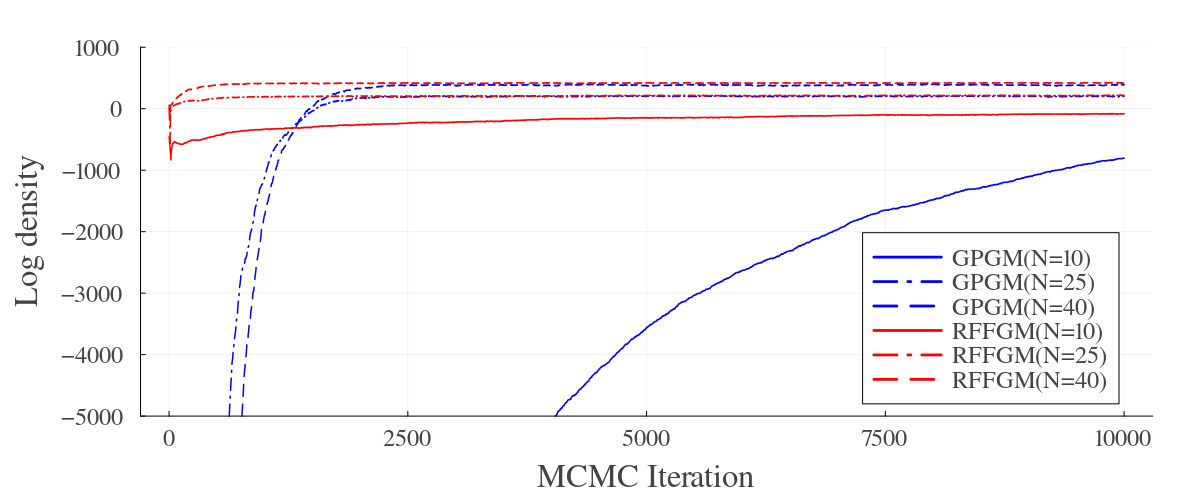

In [141]:
pl

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*